In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import Lambda, Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
print(tf.__version__)

2.3.0


In [ ]:
#Size of the image
x=300
y=300
print(x,",",y)

300 , 300


In [ ]:
!unzip -qq test13.zip

In [ ]:
!unzip -qq external_test_test13.zip

In [ ]:
print(os.getcwd())
path2="test13"

dirname1=os.path.join(os.getcwd(), path2, "training")
dirname2=os.path.join(os.getcwd(), path2, "validation")
print(dirname1)
print(dirname2)

/content
/content/test13/training
/content/test13/validation


In [ ]:
#Google Drive auth  / click on generated link and then paste it 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load model's weights from the file VGG_16_weights.h5
weights_model = '/content/drive/My Drive/datasets/vgg16_weights.h5'
#weights_model = '/content/vgg16_weights.h5'


In [ ]:
# Load VGG16 model from Keras (more models available: en https://www.tensorflow.org/api_docs/python/tf/keras/applications)
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# Turn off fully-connected and weights
pre_trained_model = VGG16(input_shape = (x, y, 3), 
                                include_top = False, 
                                weights = None)

In [ ]:
# Assign previosly loaded weights to the pre-trained model
pre_trained_model.load_weights(weights_model)

In [ ]:
# Model summary.  Layers are blocked so as not to train them
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [ ]:
# A VGG16 layers is selected, which is the last of the transfer taken
last_layer = pre_trained_model.get_layer('block4_pool') 
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 18, 18, 512)


**ARCHITECTURE DEFINITION_Fully Connection Layers**

In [ ]:
# Last layer is assigned
last_output = last_layer.output
last_output

<tf.Tensor 'block4_pool/MaxPool:0' shape=(None, 18, 18, 512) dtype=float32>

In [ ]:
#Fully-connected is added again to our model
#from tensorflow.keras.optimizers import RMSprop

##### Neural network #####
model = Flatten()(last_output)
model = Dense(1028)(model)
model = tf.nn.leaky_relu(model, alpha=0.1, name='Leaky_ReLU') 
model = Dropout(0.45)(model)
model = Dense(2, activation = 'softmax')(model)

model = Model(pre_trained_model.input, model)      
import tensorflow_addons as tfa

f1=tfa.metrics.F1Score(num_classes=2, average='weighted')
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, decay=0.0001), metrics=[f1])

from tensorflow.keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_f1_score:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_score', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
#Parameters Visualization
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        vertical_flip=True,
        horizontal_flip=True,     
)
validation_datagen = ImageDataGenerator(rescale=1/255)
batch_sizet=1
batch_sizev=1
#Read training images and resize. Binary 
train_generator = train_datagen.flow_from_directory(dirname1, #training images directory
target_size = (x, y), #Resize all images 200x200
batch_size = batch_sizet,                                                       
class_mode = 'categorical', interpolation='bicubic')

#Read validation images and resize. Binary 
validation_generator = validation_datagen.flow_from_directory(dirname2, #validation images directory
target_size = (x, y), #Resize all images 200x200
batch_size = batch_sizev,                                                     
class_mode = 'categorical', interpolation='bicubic')

Found 3531 images belonging to 2 classes.
Found 1180 images belonging to 2 classes.


In [ ]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [ ]:
tic()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=3531,
    epochs=80,
    validation_data=validation_generator,
    validation_steps=1180,
    verbose=1,
    callbacks=callbacks_list)
toc() #Returns elapsed time

In [ ]:
model.save('/content/copymovemodel.h5')
model.save_weights('/content/copymoveweights.h5')


In [ ]:
model.save('/content/drive/My Drive/datasets/weights_and_models/test11_ALL_TLmodel_VGG.h5')
model.save_weights('/content/drive/My Drive/datasets/weights_and_models/test11_ALL_TLweights_VGG.h5')

In [ ]:
from tensorflow.keras.utils import plot_model
#Graphics Model Architecture
plot_model(model, show_shapes=True, to_file='Test10.png')

**Charts**

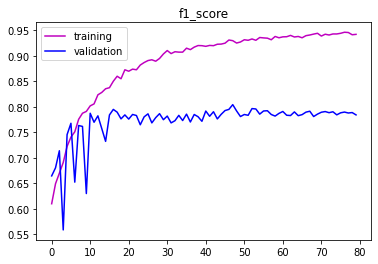

In [ ]:
import matplotlib.pyplot as plt
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']
epochs = range(len(f1_score))

plt.plot(epochs, f1_score, 'm', label='training')
plt.plot(epochs, val_f1_score, 'b', label='validation')
plt.title('f1_score')
plt.legend()
plt.show()

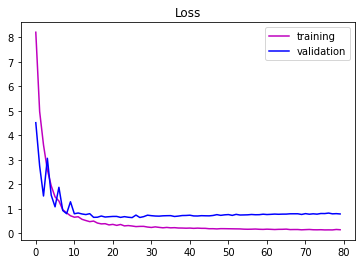

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'm', label='training')
plt.plot(epochs, val_loss, 'b', label='validation')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
#Load weights and trained model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
model = '/content/copymovemodel.h5'
weights_model = '/content/copymoveweights.h5'
model = load_model(model)
model.load_weights(weights_model)

**EXTERNAL TEST**

In [ ]:
#Original='/content/drive/My Drive/datasets/external_test_test18/a_original'
Original = os.path.join(os.getcwd(),'external_test_test13','a_original')

imagen=os.listdir(Original)
total=len(imagen)
TrueNegatives = 0
FalsePositives = 0
import cv2
import numpy as np
for i in range(total):
  path=os.path.join(Original,imagen[i])
  img=cv2.imread(path)
  img=cv2.resize(img,(x, y)) # same size that was used for training and validation
  img=np.reshape(img,[1, x, y, 3])

  prediction = model.predict(img)
  CATEGORIES = ["a_original", "b_fake"]
  pred_name = CATEGORIES[np.argmax(prediction)]
  
  if pred_name == "a_original":
    TrueNegatives = TrueNegatives+1
  elif pred_name == "b_fake":
    FalsePositives = FalsePositives+1

confusion_matrix=np.zeros((2, 2))
confusion_matrix[1,1] = TrueNegatives
confusion_matrix[1,0] = FalsePositives

In [ ]:
#Fake='/content/drive/My Drive/datasets/external_test_test18/b_fake'
Fake = os.path.join(os.getcwd(),'external_test_test13','b_fake')

imagen2=os.listdir(Fake)
total2=len(imagen2)
TruePositives = 0
FalseNegatives = 0
import cv2
import numpy as np
for i in range(total2):
  path=os.path.join( Fake, imagen2[i])
  img2=cv2.imread(path)
  img2=cv2.resize(img2,(x, y)) #same size that was used for training and validation
  img2=np.reshape(img2,[1, x, y, 3])

  prediction = model.predict(img2)
  CATEGORIES = ["a_original", "b_fake"]
  pred_name = CATEGORIES[np.argmax(prediction)]
  
  if pred_name == "a_original":
    FalseNegatives = FalseNegatives+1
  elif pred_name == "b_fake":
    TruePositives = TruePositives+1

confusion_matrix[0,1] = FalseNegatives
confusion_matrix[0,0] = TruePositives

In [ ]:
Precision = TruePositives/(TruePositives+FalsePositives)
Recall = TruePositives/(TruePositives+FalseNegatives)
f1_score = (2*Precision*Recall)/(Precision+Recall)
Accuracy = (TruePositives + TrueNegatives)/(TruePositives + TrueNegatives + FalsePositives + FalseNegatives)

print("External test results:")
print("Precision: ", Precision)
print("Recall: ", Recall)
print("f1_score: ", f1_score)
print("Accuracy: ", Accuracy)
print("confusion_matrix: ")
print(confusion_matrix)